# Expected Goals (XG)
---



- This is somewhat of a deviation from our team evaluation unit. This more falls under the category of play evaluation. However, we will see how this can be aggregated up to be part of a player evaluation framework and then to an overall team evaluation framework.
- The data is provided on blackboard. However, if you wanted to obtain it yourself, there are a couple of ways to do it.
  - https://data.scorenetwork.org/hockey/nhl-shots.html. As you can see from the link above, you can use the `hockeyR` package to pull data in directly from R. This link also provides a data dictionary for the relevant variables.
  - I haven't looked into this python package yet, but it may have similar information: https://py.sportsdataverse.org/docs/nhl/



## Why do we care about expected goals (XG) in the first place?
- Not all shots on a goal have the same (expected) value.
- Some shots may be considered good or bad shots on goal depending on several factors. For example, if a player takes a shot from very far away, would you expect it's probability of ending as a goal to be higher or lower than a shot that's much closer to the net? This might seem like there is an obvious answer, but again, this could depend on the situation.
  - My gut instinct would be to say that the closer shot is a higher quality shot and therefore is more likely to to end as a goal.
  - However, what if the closer shot was at a very tough angle as opposed to the far distance shot?
  - What if the opposing team pulled their goalie so that no one was directly guarding the net and the far distance shot didn't need to be as precise as in a typical situation?

- Note that hockey is not the only sport that can benefit from an XG type of metric. Soccer is also big on this kind of a metric. There are other similar metrics in basketball and football that you can look up too.

- For a nice introduction for hockey: https://www.nhl.com/kraken/news/analytics-with-alison-expected-goals-327728890

- In this tutorial, we will explore hockey data, but you can try to come up with something similar using soccer data. If you want to play around with great data for soccer, I highly recommend looking at the following python package: https://github.com/statsbomb/statsbombpy
- On this, here (https://www.kaggle.com/code/gabrielmanfredi/expected-goals-player-analysis) is an excellent notebook example of analysis done for soccer. The principles in this analysis can be carried over here.



In [1]:
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import classification_report

from sklearn.calibration import calibration_curve


import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
data_path = '../drive/MyDrive/data/Hockey/nhl-shots-2021.csv'

In [4]:
df = pd.read_csv(data_path)

In [5]:
df.shape

(160573, 22)

In [6]:
df.head(3)

,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,event_team,event_goalie_name,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
0,2021020001,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,1137,3537,0,0,Tampa Bay Lightning,Pittsburgh Penguins,Tampa Bay Lightning,Tristan.Jarry,NaN,Steven.Stamkos,Shooter,Tristan.Jarry,Goalie,EV,61.0,-32.0,42.5,48.8
1,2021020001,Zach Bogosian shot blocked shot by Brock McGinn,BLOCKED_SHOT,1,1115,3515,0,0,Tampa Bay Lightning,Pittsburgh Penguins,Tampa Bay Lightning,NaN,NaN,Zach.Bogosian,Shooter,Brock.McGinn,Blocker,EV,60.0,-17.0,NaN,NaN
2,2021020001,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,1096,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,Pittsburgh Penguins,Andrei.Vasilevskiy,NaN,Brock.McGinn,Shooter,Andrei.Vasilevskiy,Goalie,EV,-65.0,19.0,30.6,38.4


In [7]:
df['event_player_2_type'].value_counts(dropna=False)

,count
event_player_2_type,
Goalie,81326
Blocker,38224
Unknown,32485
Assist,8164
NaN,374


In [8]:
# Look at the missing values for each column
df.isna().sum()

,0
game_id,0
description,0
shot_outcome,0
period,0
period_seconds_remaining,0
game_seconds_remaining,0
home_score,0
away_score,0
home_name,0
away_name,0


In [9]:
display(df['shot_outcome'].value_counts(dropna=False))
display(df['shot_outcome'].value_counts(dropna=False, normalize=True))

,count
shot_outcome,
SHOT,80648
BLOCKED_SHOT,38224
MISSED_SHOT,32765
GOAL,8936


,proportion
shot_outcome,
SHOT,0.502251
BLOCKED_SHOT,0.238047
MISSED_SHOT,0.204050
GOAL,0.055651


- Note that this is going to be an imbalanced problem. The target variable that we will create will be Goal/No-Goal.
- Regardless of the availability of which features we use, there will always be far fewer goals than no-goals.
- Therefore, we need to take special care when evaluating our models.

## Definitions

`shot_outcome`
- `BLOCKED_SHOT`: Blocked shot by a non-goalie
- `GOAL`: Shot went in
- `MISSED_SHOT`: Shot that missed the net
- `SHOT`: Shot on net that was saved by a goalie

`shot_angle`
- Numeric angle (in degrees) to center of net for unblocked shot events
- This means that for blocked shots, this variable has missing values (you can also check to verify)

`shot_distance`
- Numeric distance (in feet) to center of net for unblocked shot events
- This means that for blocked shots, this variable has missing values (you can also check to verify)

## Exploratory Data Analysis (EDA)
- Even though we're going to be focused on prediction in this tutorial, it's always worth visualizing the data with a focus on our goal, predicting the probability of goals.

### Shot Outcomes by missingness of shot angle/distance variable

In [10]:
df_target_summary = df['shot_outcome'].value_counts(normalize=True).reset_index()
df_target_summary_nonmiss_angle = df[~df['shot_angle'].isna()]['shot_outcome'].value_counts(normalize=True).reset_index()
df_target_summary = pd.concat([df_target_summary,df_target_summary_nonmiss_angle])
df_target_summary['missing_angle'] = [0,0,0,0,1,1,1]
df_target_summary

,shot_outcome,proportion,missing_angle
0,SHOT,0.502251,0
1,BLOCKED_SHOT,0.238047,0
2,MISSED_SHOT,0.204050,0
3,GOAL,0.055651,0
0,SHOT,0.659164,1
1,MISSED_SHOT,0.267799,1
2,GOAL,0.073037,1


<Axes: xlabel='shot_outcome', ylabel='proportion'>

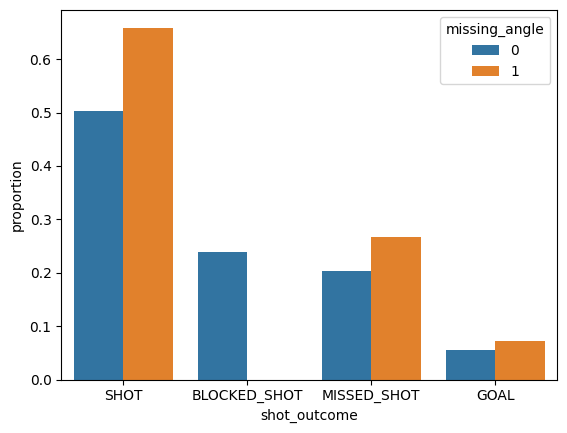

In [11]:
sns.barplot(x='shot_outcome', y='proportion',data=df_target_summary, hue='missing_angle')

- As we can see from the plot above, that if we were to remove shots with missing values for shot angle and distance, the relative percentage of goals does not change too much and we will still have an imbalanced target issue to deal with.

<Axes: xlabel='shot_outcome', ylabel='shot_angle'>

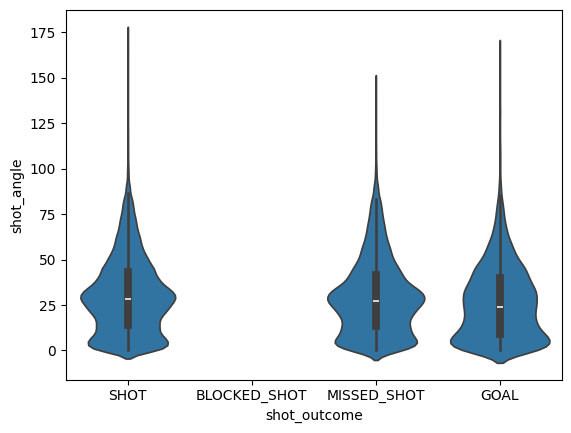

In [12]:
sns.violinplot(x='shot_outcome', y='shot_angle', data=df)

- The widest part of the goal distribution is close to zero degrees off from the center of the goal. This is a bump around 25 degrees of as well.
- We see these multi-modal distributions across the shots blocked by the goalie and the missed shots.
- This all suggests that higher quality shots have angles closer to the center of the net.

<Axes: xlabel='shot_outcome', ylabel='shot_distance'>

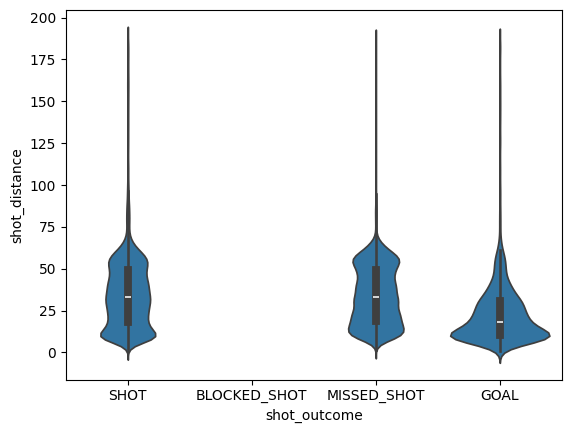

In [13]:
sns.violinplot(x='shot_outcome', y='shot_distance', data=df)

- Most of the goals occur from shots relatively close to the net.
- Other non-goal shots are more spread out in terms of distance from the net.
- This suggests that higher quality shots are ones that are closer to the net.

<Axes: xlabel='x_fixed', ylabel='y_fixed'>

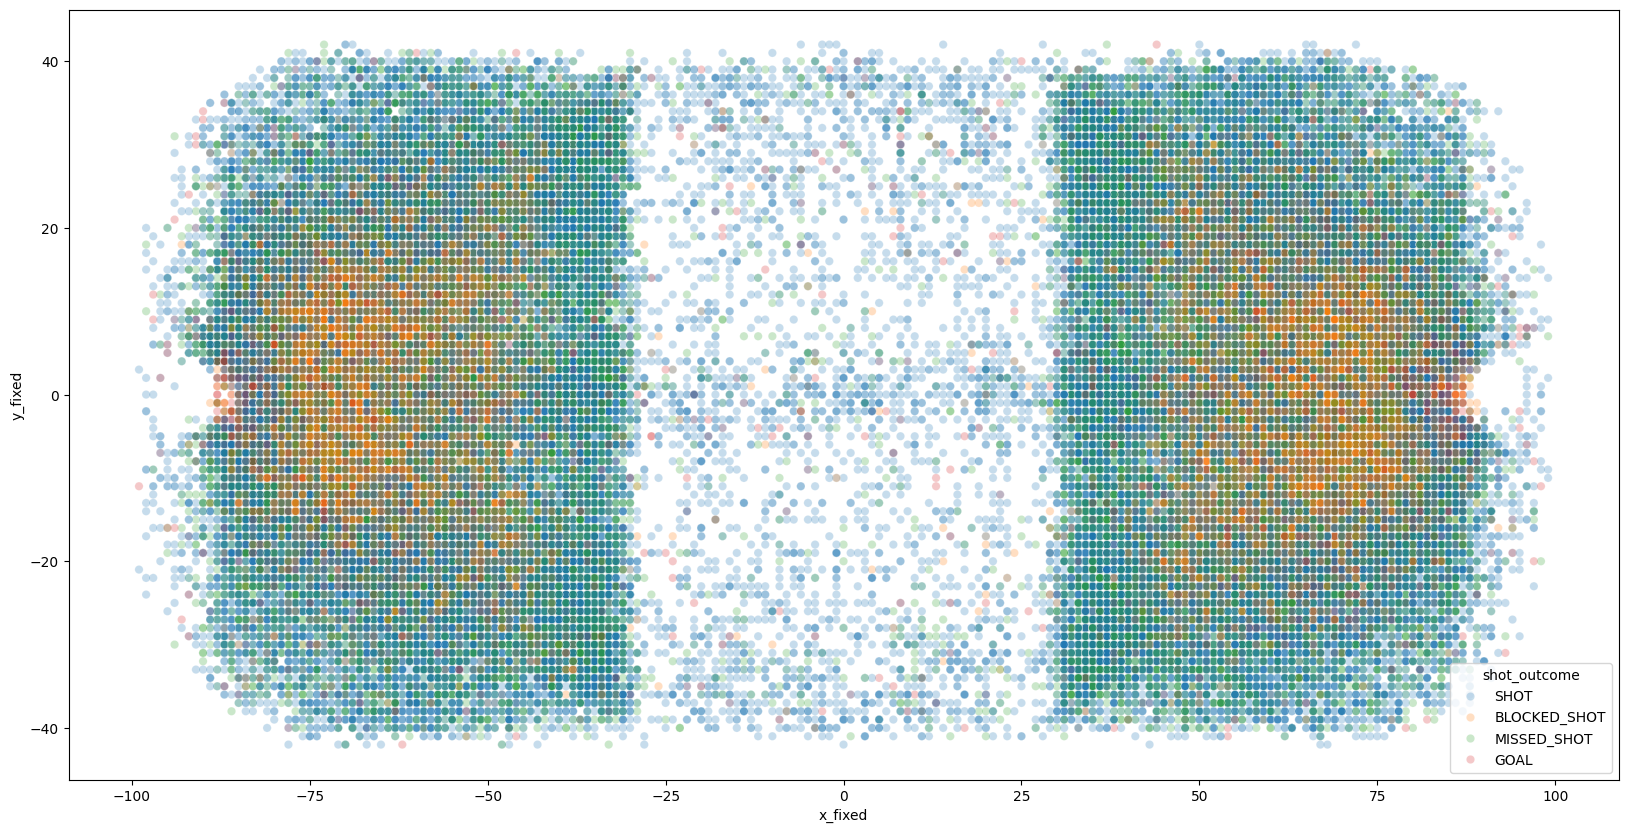

In [14]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='x_fixed', y='y_fixed', data=df, hue='shot_outcome', alpha=.25)

- With this above plot, we can clearly see the geometry of the ice rink, the nets and the center.
- This visual supports our hypotheses above that shot angle and distance do appear to affect shot quality.

There are certainly other variables we could explore and potentially include, but will focus on these.

### Create Target
For simplicity , we will only consider shots that do not get blocked by players other than the goalie.

In [18]:
# Our initial model is only based on shot angle and shot distance --> remove blocked shots (missing values)
df_mod1 = df[df['shot_outcome']!='BLOCKED_SHOT']
y = np.where(df_mod1['shot_outcome']=='GOAL', 1, 0)

cols_to_keep = ['event_team','event_goalie_name','event_player_1_name', 'shot_angle','shot_distance','x_fixed','y_fixed']

X_train, X_test, y_train, y_test = train_test_split(df_mod1[cols_to_keep], y, test_size=0.3, random_state=123)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(85644, 7) (36705, 7)
(85644,) (36705,)


### Develop Initial Logistic Regression Model

In [19]:
# Develop initial model with statsmodels just to see some statistical output first. Then we'll move onto using scikit-learn.
X1_train = X_train[['shot_angle','shot_distance']]
X1_train = sm.add_constant(X1_train)


In [21]:
X1_train.head()

,const,shot_angle,shot_distance
93979,1.0,5.8,49.3
53763,1.0,28.4,56.8
29771,1.0,27.5,56.4
154624,1.0,40.1,24.8
22365,1.0,2.9,20.0


In [24]:
1/(1+np.exp(2.557))

np.float64(0.07195762435680769)

In [23]:
logreg_sm_baseline = sm.GLM(endog=y_train, exog=X1_train.iloc[:,0], family=sm.families.Binomial()).fit()
logreg_sm = sm.GLM(endog=y_train, exog=X1_train, family=sm.families.Binomial()).fit()

print('Baseline Model (intercept only) ...')
print(logreg_sm_baseline.summary())
print('\n')
print('Initial Model with Predictors ...')
print(logreg_sm.summary())

Baseline Model (intercept only) ...
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                85644
Model:                            GLM   Df Residuals:                    85643
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22155.
Date:                Thu, 03 Apr 2025   Deviance:                       44309.
Time:                        21:14:57   Pearson chi2:                 8.56e+04
No. Iterations:                     6   Pseudo R-squ. (CS):         -4.441e-16
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2

- How do we interpret these results?
- First focus on the baseline model...
  - Coef = -2.557 --> $\log(\frac{p}{1-p}) = -2.557 \implies \frac{p}{1-p} = e^{-2.557} = 0.0775 \implies p = \frac{1}{1+e^{-(-2.557)}} = 0.072$
  - This means that without considering any predictors, we expect a non-blocked shot to become a goal about 7.2% of the time.
  - This makes sense because when we computed the proportions of the shot outcomes for non-blocked shots, goals occurred about 7.3% of the time. So, effectively, without using any predictors, we are just getting back the proportion of goals in the data.
- Second, consider our model with multiple features.
  - First if we want to compare this model to the baseline model in terms of overall statistical measures, we can look at the log-likelihood and the pseudo R-squared metrics on the top right.
    - We generally want the log-likelihood to be higher, which we have here.
    - We generally want the pseudo R-squared metric to be higher, which we also see here.
    - We also see 3 of our 4 features being statistically significant, meaning, the corresponding slopes being significantly different from 0.
    - In our course, we have yet to discuss how to interpret numeric features parameters within a logistic regression. To do this we typically see how the odds of scoring change with a 1 unit change in the variable.

In our case, we have 4 features and 1 intercept. The odds of scoring for a given shot angle $x_1$ are:
$$\frac{p(x_1)}{1-p(x_1)} = e^{\beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4}.$$
The odds of scoring for a 1 degree increase in shot angle $x_1+1$ are:
$$\frac{p(x_1+1)}{1-p(x_1+1)} = e^{\beta_0 + \beta_1(x_1+1) + \beta_2x_2 + \beta_3x_3 + \beta_4x_4}.$$
Take the ratio of these two odds (called the "odds ratio") and see what comes out.
$$\text{Odds Ratio} = \frac{p(x_1+1)/[1-p(x_1+1)]}{p(x_1)/[1-p(x_1)]} = \frac{e^{\beta_0 + \beta_1(x_1+1) + \beta_2x_2 + \beta_3x_3 + \beta_4x_4}}{e^{\beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4}}$$

Using a little algebra, almost everything cancels out.
$$\text{Odds Ratio} = e^{\beta_1}$$

With our estimated model, for `shot_angle`, we have $e^{-0.0123} = 0.987 \approx 0.99$. So, for each additional degree away from the center of the net, the odds of scoring decrease by about 1%.

Similarly, we can interpret the other estimated parameters.

For `shot_distance`, we have $e^{-0.0348} = 0.966 \approx 0.97$. So, for each additional foot away from the center of the net, the odds of scoring decrease by about 3%.

      

### Model Evaluation
- We can do all kinds of model evaluations here.
- How calibrated are our predicted probabilities compared to simple benchmarks.
  - Look at the Brier Score or Log Loss
  - What are some examples of simple benchmarks here?
    - Model that always predicts no-goal
    - Model that predicts goal randomly
    - Model that predicts goal randomly but with a rate at which goals actually occurr (~7%)
- We can evaluate the classification metrics that we've discussed in class.
  - Accuracy (is this a trustworthy metric in this example problem)?
    - Likely not! This is a highly imbalanced dataset. So if we built a model that simply predicts no-goal 100% of the time, our accuracy would be about 93%! This is not a helpful model.
  - Instead we might consider precision, recall, f1 scores, as well as the precision-recall curve to determine optimal thresholds. Notice that if we were to use a decision threshold of 0.5 for predicting a shot to be a goal, we would never predict any goals. Our predicted probabilities are quite low. So, a more useful threshold might be 0.10. We can use the precision-recall curve to get an idea of our "optimal" decision threshold given our estimated logistic regression model.

In [25]:
X1_test = sm.add_constant(X_test)


df_y_pred = pd.DataFrame()
df_y_pred['y_test'] = y_test
df_y_pred['y_pred_test'] = logreg_sm.predict(X1_test[['const','shot_angle','shot_distance']]).reset_index(drop=True)
df_y_pred.head()

,y_test,y_pred_test
0,0,0.151194
1,0,0.165393
2,1,0.059429
3,0,0.071584
4,0,0.026932


In [26]:
df_y_pred.describe()

,y_test,y_pred_test
count,36705.000000,36705.000000
mean,0.075548,0.072007
std,0.264278,0.043280
min,0.000000,0.000425
25%,0.000000,0.038076
50%,0.000000,0.060077
75%,0.000000,0.099774
max,1.000000,0.233315


Text(0.5, 1.0, 'Logistic Regression')

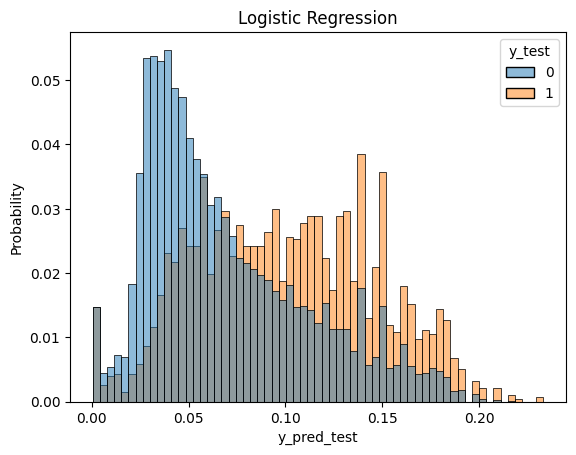

In [27]:
sns.histplot(x='y_pred_test', hue='y_test', data=df_y_pred, stat='probability', common_norm=False)
plt.title('Logistic Regression')

- We see the distribution of predicted goal probabilities tends to be larger for goals (orange) than for non-goals (blue).

#### Probability Calibration

In [ ]:
calibration_curve(df_y_pred['y_test'], df_y_pred['y_pred_test'], n_bins=50)

(array([0.05128205, 0.02048374, 0.04719294, 0.07004922, 0.09756098,
        0.12959894, 0.14438095, 0.16595745, 0.16031196, 0.2079646 ,
        0.41666667, 1.        ]),
 array([0.0091183 , 0.03131043, 0.04928462, 0.06916273, 0.08931476,
        0.10955168, 0.12969512, 0.14971917, 0.16880296, 0.18652487,
        0.20695554, 0.22923834]))

In [ ]:
df_y_pred['y_pred_test'].shape, df_y_pred['y_pred_test'].nunique()

((36705,), 3786)

In [28]:
def brier_score(preds, labels):
  return np.mean((labels-preds)**2)

def log_loss(preds, labels):
  return -np.mean(labels*np.log(preds) + (1-labels)*np.log(1-preds))

print(f"Logistic Model --> Brier Score: {brier_score(preds=df_y_pred['y_pred_test'], labels=df_y_pred['y_test'])}, Log-Loss: {log_loss(preds=df_y_pred['y_pred_test'], labels=df_y_pred['y_test'])}")
print(f"Benchmark 3 --> Brier Score: {brier_score(preds=np.repeat(.07,len(df_y_pred)), labels=df_y_pred['y_test'])}, Log-Loss: {log_loss(preds=np.repeat(.07,len(df_y_pred)), labels=df_y_pred['y_test'])}")
print(f"Benchmark 1 --> Brier Score: {brier_score(preds=np.repeat(0,len(df_y_pred)), labels=df_y_pred['y_test'])}, Log-Loss: {log_loss(preds=np.repeat(0,len(df_y_pred)), labels=df_y_pred['y_test'])}")
print(f"Benchmark 2 --> Brier Score: {brier_score(preds=np.repeat(.5,len(df_y_pred)), labels=df_y_pred['y_test'])}, Log-Loss: {log_loss(preds=np.repeat(0.5,len(df_y_pred)), labels=df_y_pred['y_test'])}")



Logistic Model --> Brier Score: 0.06745793883235837, Log-Loss: 0.2542068065170167
Benchmark 3 --> Brier Score: 0.06987152976433728, Log-Loss: 0.26799065063850247
Benchmark 1 --> Brier Score: 0.07554829042364801, Log-Loss: inf
Benchmark 2 --> Brier Score: 0.25, Log-Loss: 0.6931471805599453


<ipython-input-28-fb8e60a52594>:5: RuntimeWarning: divide by zero encountered in log
  return -np.mean(labels*np.log(preds) + (1-labels)*np.log(1-preds))


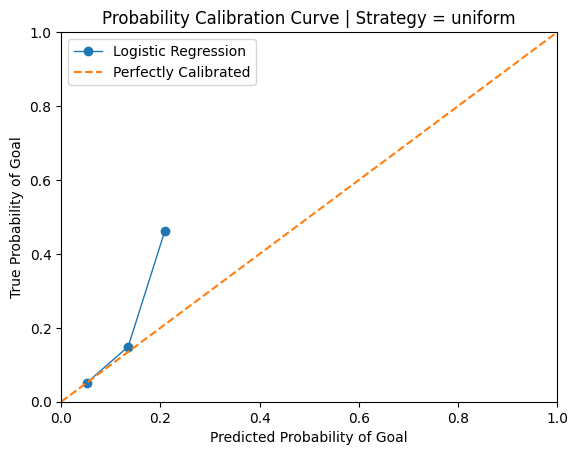

In [29]:
true_goal_probs, pred_goal_probs = calibration_curve(df_y_pred['y_test'], df_y_pred['y_pred_test'], n_bins=10, strategy='uniform')

plt.plot(pred_goal_probs,
         true_goal_probs,
         marker='o',
         linewidth=1,
         label='Logistic Regression')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         label='Perfectly Calibrated')
plt.xlabel('Predicted Probability of Goal')
plt.ylabel('True Probability of Goal')
plt.title('Probability Calibration Curve | Strategy = uniform')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc='best')

A few things to note here why we probably don't want `strategy='uniform'`.

  - There are only 39 observations in the the third bin which has predicted probabilities above 0.2036.
  - Even though 46% of these 39 observations did result in goals, the small sample size makes it difficult to reliably estimate the true probability of scoring in this bin. Therefore, it's not surprising to see such a large deviation from the perfect calibration line for this third group of shots.


  For additional details, search for `calibration_curve` in the actual code behind this scikit-learn function: https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/calibration.py#L955. If you really want to understand the inner workings of how this function works, play around with the original code and understand functions like `np.linspace()`, `np.searchsorted()`, and `np.bincount()`.

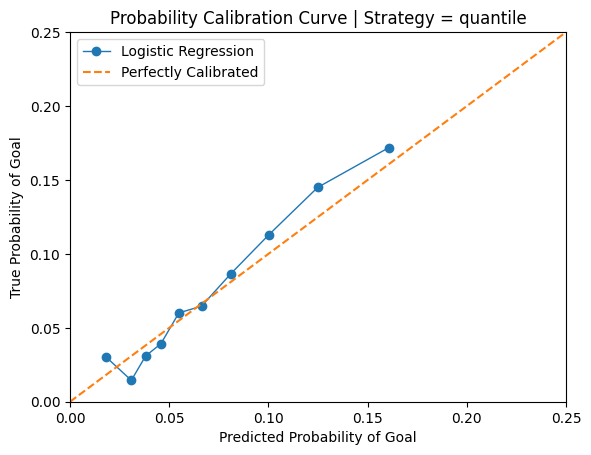

In [ ]:
true_goal_probs, pred_goal_probs = calibration_curve(df_y_pred['y_test'], df_y_pred['y_pred_test'], n_bins=10, strategy='quantile')

plt.plot(pred_goal_probs,
         true_goal_probs,
         marker='o',
         linewidth=1,
         label='Logistic Regression')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         label='Perfectly Calibrated')
plt.xlabel('Predicted Probability of Goal')
plt.ylabel('True Probability of Goal')
plt.title('Probability Calibration Curve | Strategy = quantile')
plt.xlim([0,.25])
plt.ylim([0,.25])
plt.legend(loc='best')

- Our predicted probabilities are pretty well calibrated...

- Our model's predicted probabilities are slightly better than a model that always predicts goals with probabilities 0.07.
- Our model's predicted probabilities are better than a model that always predicts no-goal.

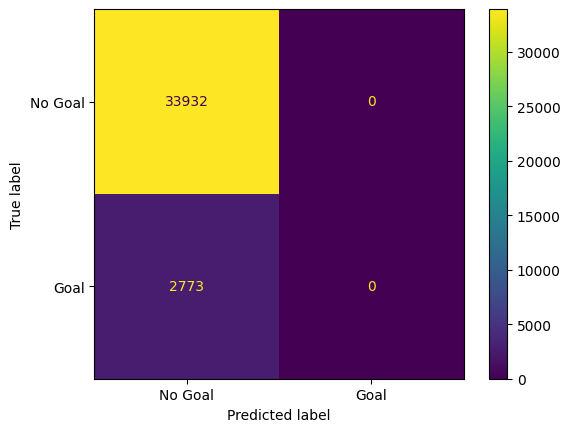

In [ ]:
# Use 0.5 as default threshold
cm = confusion_matrix(df_y_pred['y_test'], df_y_pred['y_pred_test']>.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['No Goal', 'Goal'])
disp.plot()

[0.00042491 0.00043033 0.00044228 ... 0.21514427 0.22108477 0.23331512]


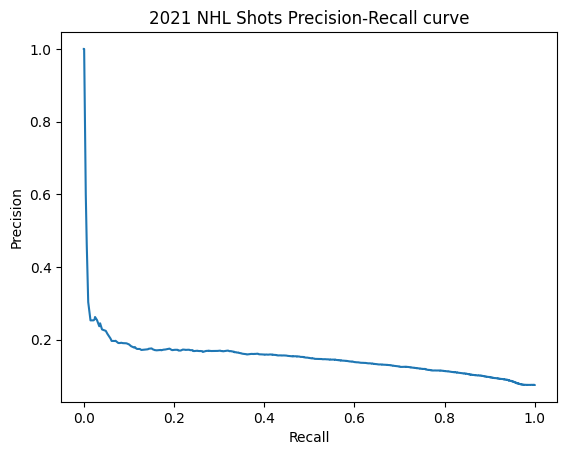

In [31]:
precision, recall, thresholds = precision_recall_curve(df_y_pred['y_test'], df_y_pred['y_pred_test'])
plt.plot(recall, precision)

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("2021 NHL Shots Precision-Recall curve")
print(thresholds)


- Given such an imbalanced dataset, we can't readily get both objectively good recall and precision scores.
- We may require a certain minimum level of recall and maximize precision (or vice versa).
- There may also be other ways to determine the best threshold.

Suppose I want to detect at least 40% of goals scored. Let's select the decision threshold that maximizes the precision with this constraint.

In [ ]:
len(precision), len(recall), len(thresholds)

(3787, 3787, 3786)

In [ ]:
precision[:10]

array([0.07554829, 0.07555035, 0.07555241, 0.07555447, 0.07555652,
       0.07555858, 0.07556064, 0.0755627 , 0.07556476, 0.07556682])

In [ ]:
thresholds[:10]

array([0.00042491, 0.00043033, 0.00044228, 0.00044684, 0.0004506 ,
       0.00045641, 0.00045968, 0.00046056, 0.00046137, 0.00046267])

In [ ]:
thresholds[-10:]

array([0.1851056 , 0.18521708, 0.18719103, 0.19254905, 0.19802307,
       0.20361347, 0.20932049, 0.21514427, 0.22108477, 0.23331512])

In [32]:
df_pr = pd.DataFrame({'precision':precision[:-1],
              'recall':recall[:-1],
              'thresholds':thresholds})
top_thresholds = df_pr[df_pr['recall']>=.4].sort_values('precision', ascending=False).head()
optimal_thresh = top_thresholds['thresholds'].iloc[0]
optimal_thresh

np.float64(0.11298942039967702)

In [35]:
display(df_pr.head())
display(df_pr.tail())


,precision,recall,thresholds
0,0.075548,1.0,0.000425
1,0.075550,1.0,0.000430
2,0.075552,1.0,0.000442
3,0.075554,1.0,0.000447
4,0.075557,1.0,0.000451


,precision,recall,thresholds
3781,0.461538,0.006491,0.203613
3782,0.600000,0.004327,0.209320
3783,0.857143,0.002164,0.215144
3784,1.000000,0.001082,0.221085
3785,1.000000,0.000721,0.233315


- Looks like we can select a threshold of 0.112989 (roughly probability threshold of 11%).

In [ ]:
df_y_pred['y_pred_class'] = np.where(df_y_pred['y_pred_test']>optimal_thresh,1,0)

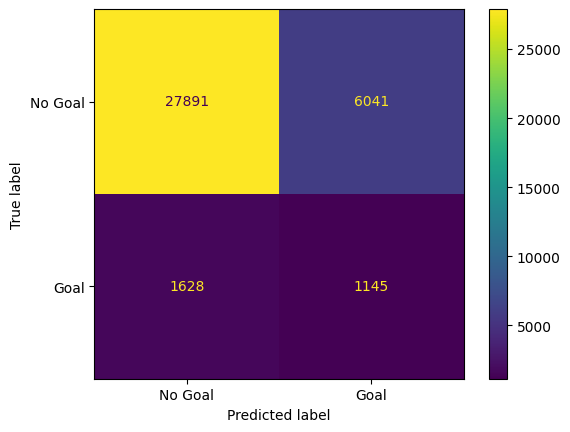

In [ ]:
cm = confusion_matrix(df_y_pred['y_test'], df_y_pred['y_pred_class'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['No Goal', 'Goal'])
disp.plot()

In [ ]:
print(classification_report(df_y_pred['y_test'], df_y_pred['y_pred_class']))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     33932
           1       0.16      0.41      0.23      2773

    accuracy                           0.79     36705
   macro avg       0.55      0.62      0.55     36705
weighted avg       0.89      0.79      0.83     36705



- With this threshold, we can obtain an overall accuracy of 79% (again, not the most informative here).
- We have a 41% recall on goals scored and 16% precision.
- F1-Score is a harmonic average of the precision and recall, so it's similar to the idea of overall accuracy but better when there are imbalanced data sets.
- There are also various other metrics on here that might be worth looking at and making decisions based on this model.

## Shot Quality
Now that we've built a model that predicts goal probability for a given shot, we can think of these probabilities as "shot quality." The higher the goal probability, the higher the quality.

We can aggregate this shot quality to various levels to give a say on which players and teams have the best quality shots.

### Aggregate to Player Level

If $Y_i$ is the number of goals scored for the $i^{th}$ shot, then $Y_i$ can only take values 1 (goal) or 0 (no-goal). The **expected** number of goals for the $i^{th}$ shot is $$\mathbb{E}(Y_i) = 1 \cdot \mathbb{P}(Y_i = 1) + 0 \cdot \mathbb{P}(Y_i = 0) = \mathbb{P}(Y_i = 1).$$ This is exactly what our individual shot predicted probabilities represent.

If a player takes $k$ shots, then his **expected** number of goals is $$\mathbb{E}(Y_1 + Y_2 + \ldots Y_k) = \mathbb{E}(Y_1)+\mathbb{E}(Y_2)+\dots+\mathbb{E}(Y_k) = \mathbb{P}(Y_1=1)+\mathbb{P}(Y_2=1)+\dots+\mathbb{P}(Y_k=1).$$

This means that for a player who takes $k$, to get his expected goals from those $k$ shots, all we need to do is add up his individual predicted goal probabilities from all of his shots.

In [ ]:
df_mod1 = sm.add_constant(df_mod1)
df_mod1['y_pred'] = logreg_sm.predict(df_mod1[['const','shot_angle','shot_distance']])

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)


In [ ]:
df_mod1['goal'] = np.where(df_mod1['shot_outcome']=='GOAL',1,0)

In [ ]:
# y_pred_train = logreg_sm.predict(X1_train)
# df_train = pd.concat([X_train, y_pred_train], axis=1).reset_index()
# df_train.rename(columns={0:'y_pred_train'}, inplace=True)
# df_train = pd.concat([df_train, df_y_train], axis=1).reset_index()

# df_train.head()

In [ ]:
player_XG = df_mod1.groupby('event_player_1_name')[['y_pred','goal']] \
.agg('sum') \
.reset_index() \
.rename(columns={'y_pred': 'player_XG', 'goal':'num_goals'}) \
.sort_values('player_XG', ascending=False)

# Compute the difference
player_XG['diff'] = player_XG['num_goals']-player_XG['player_XG']

# Compute the ratio
player_XG['ratio'] = player_XG['num_goals']/player_XG['player_XG']

display(player_XG.head())
display(player_XG.tail())

,event_player_1_name,player_XG,num_goals,diff,ratio
220,Connor.McDavid,43.666299,57,13.333701,1.305355
87,Auston.Matthews,43.271602,66,22.728398,1.525250
686,Nathan.MacKinnon,39.254754,46,6.745246,1.171833
983,Zach.Hyman,39.222388,38,-1.222388,0.968834
390,Jake.Guentzel,39.069484,49,9.930516,1.254176


,event_player_1_name,player_XG,num_goals,diff,ratio
294,Elvis.Merzlikins,0.001404,0,-0.001404,0.0
761,Paul.LaDue,0.001179,0,-0.001179,0.0
352,Igor.Shesterkin,0.001177,0,-0.001177,0.0
248,David.Rittich,0.000836,0,-0.000836,0.0
811,Robin.Lehner,0.000463,0,-0.000463,0.0


In [ ]:
player_XG[['player_XG','num_goals']].corr()

,player_XG,num_goals
player_XG,1.000000,0.936352
num_goals,0.936352,1.000000


- Note that there is a higher correlation between number of goals a player actually scored and the number he was expected to score.

#### Player Evaluation
- Who are the best goal scorers?
- Who are the players who to take the highest quality shots from an angle-distance point of view?
- Who are the best scorers above their expectations?

Text(0.5, 1.0, 'Top 10 for XG')

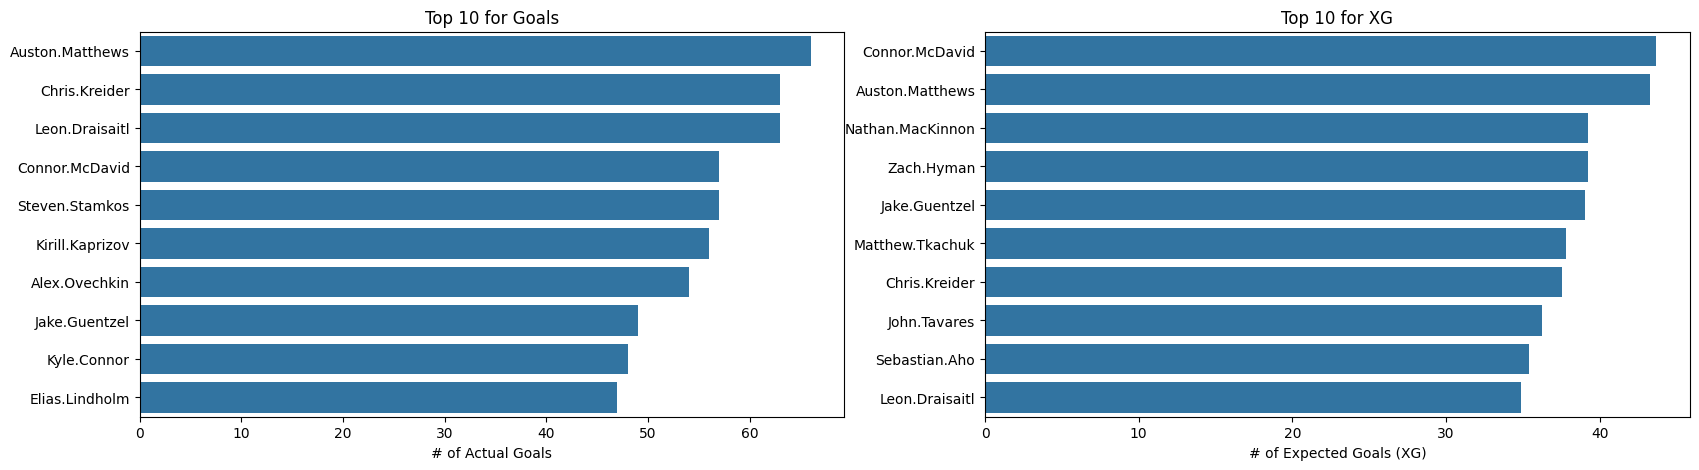

In [ ]:
df_num_goals = player_XG.sort_values('num_goals', ascending=False).head(10)
df_exp_goals = player_XG.sort_values('player_XG', ascending=False).head(10)

fig, axs = plt.subplots(1,2, figsize=(20,5))

sns.barplot(x='num_goals',y='event_player_1_name', data=df_num_goals, ax=axs[0])
axs[0].set_xlabel('# of Actual Goals')
axs[0].set_ylabel('')
axs[0].set_title('Top 10 for Goals')

sns.barplot(x='player_XG',y='event_player_1_name', data=df_exp_goals, ax=axs[1])
axs[1].set_xlabel('# of Expected Goals (XG)')
axs[1].set_ylabel('')
axs[1].set_title('Top 10 for XG')

- Perhaps players who are in the top 10 for goals scored but not in top 10 for expected goals are taking (and making) lower quality/more difficult shots from a angle-distance perspective. It's also possible that these players are more skilled at scoring and don't necessarily need highest quality shots. It's also possible that there could be additional importance factors that should be accounted for when building our logistic regression for goal probabilities.
- On the other hand, players who are top 10 in expected goals but not in goals scored could potentially be getting unlucky. It's also possible that our model is overestimating their shot quality by not including potentially other important factors that influence shot quality (e.g., distance to closest defender).
- There could also be other explanations for this discrepancy. Can you think of any others?

Text(0.5, 1.0, 'Top 10 for Actual Goals / Expected Goals')

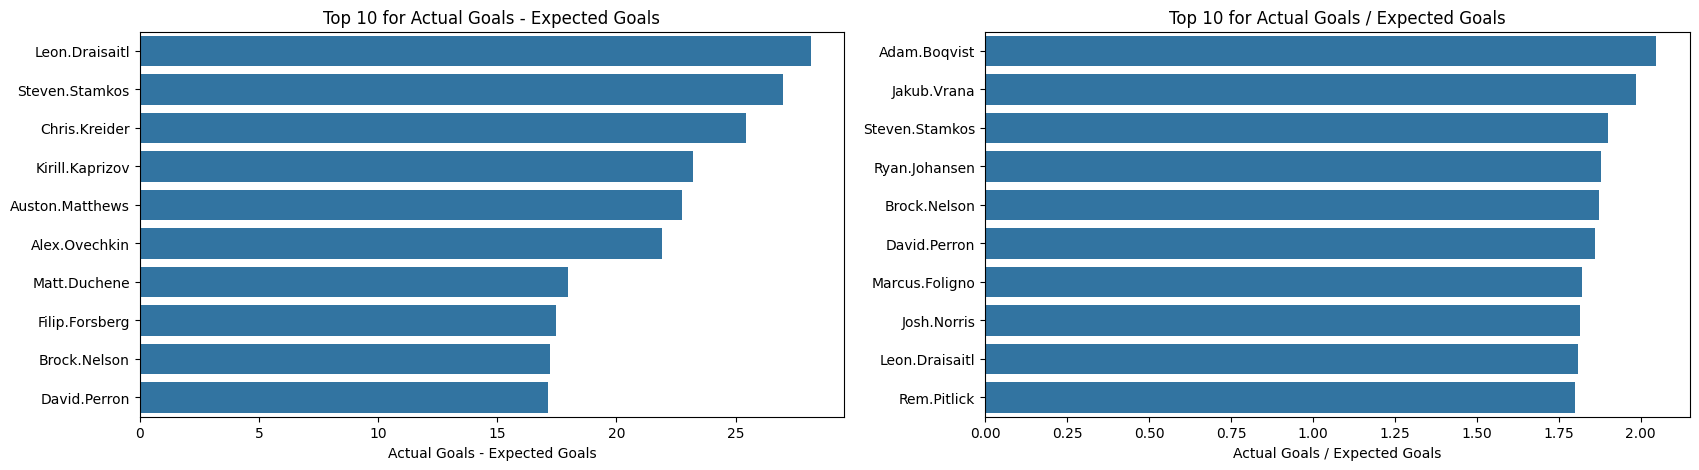

In [ ]:
df_diff_goals = player_XG.sort_values('diff', ascending=False).head(10)
df_ratio_goals = player_XG.sort_values('ratio', ascending=False)
df_ratio_goals = df_ratio_goals[df_ratio_goals['num_goals']>=5].head(10)

fig, axs = plt.subplots(1,2, figsize=(20,5))

sns.barplot(x='diff',y='event_player_1_name', data=df_diff_goals, ax=axs[0])
axs[0].set_xlabel('Actual Goals - Expected Goals')
axs[0].set_ylabel('')
axs[0].set_title('Top 10 for Actual Goals - Expected Goals')

sns.barplot(x='ratio',y='event_player_1_name', data=df_ratio_goals, ax=axs[1])
axs[1].set_xlabel('Actual Goals / Expected Goals')
axs[1].set_ylabel('')
axs[1].set_title('Top 10 for Actual Goals / Expected Goals')


- Steven Stamkos scored about 27 goals **more** than what was expected of him based on his shot angles and distances. Given the quality of shots that he took, the average would score about 35 goals, but Stamkos actually scored 57.
- Adam Boqvist scored more than 2 goals per 1 expected goal. Given the quality shots that he took, the average player would score about 5 goals whereas Johansen scored 11.

In [ ]:
display(df_diff_goals)
display(df_ratio_goals)

,event_player_1_name,player_XG,num_goals,diff,ratio
557,Leon.Draisaitl,34.858771,63,28.141229,1.807293
883,Steven.Stamkos,29.995962,57,27.004038,1.900256
187,Chris.Kreider,37.568785,63,25.431215,1.676924
532,Kirill.Kaprizov,32.796031,56,23.203969,1.707524
87,Auston.Matthews,43.271602,66,22.728398,1.525250
30,Alex.Ovechkin,32.089892,54,21.910108,1.682773
618,Matt.Duchene,29.040785,47,17.959215,1.618414
316,Filip.Forsberg,26.539794,44,17.460206,1.657888
149,Brock.Nelson,19.768506,37,17.231494,1.871664
247,David.Perron,19.884392,37,17.115608,1.860756


,event_player_1_name,player_XG,num_goals,diff,ratio
3,Adam.Boqvist,5.375092,11,5.624908,2.046477
400,Jakub.Vrana,6.546172,13,6.453828,1.985893
883,Steven.Stamkos,29.995962,57,27.004038,1.900256
827,Ryan.Johansen,13.831725,26,12.168275,1.879737
149,Brock.Nelson,19.768506,37,17.231494,1.871664
247,David.Perron,19.884392,37,17.115608,1.860756
587,Marcus.Foligno,12.622535,23,10.377465,1.822138
495,Josh.Norris,19.843729,36,16.156271,1.814175
557,Leon.Draisaitl,34.858771,63,28.141229,1.807293
796,Rem.Pitlick,9.446352,17,7.553648,1.799636


#### Best Goalies
- We might also be interested in which goalies performed the best.
- Repeat the above exercise but for goalies.
  - Who are the best goalies?
  - How might you interpret their measures?

- If we were to include other variables we could be all kinds of cuts and perofrm similar analyses. Feel free to play around with what we have here.

## Aggregate to the Team Level
- Now that we know who the best players are in terms of scoring and shot quality (XG), how do all the teams stack up?
- How do we aggregate to the team level? We can follow the same procedure as before.

If there are $N$ players on a given team, then $Y_{ij}$ represents the $i^{th}$ player's $j^{th}$ shot outcome. We know that the expected goals for the $i^{th}$ player is $$XG_i = \mathbb{E}(Y_{i1} + Y_{i2} + \dots Y_{ik}) = \mathbb{P}(Y_{i1}=1)+\mathbb{P}(Y_{i2}=1)+\dots + \mathbb{P}(Y_{ik}=1).$$ Then, the team's expected goals is simply a sum of all players goal probabilities on all shots. $$XG_{Team} = \sum_{i=1}^{N} \sum_{j=1}^{k}\mathbb{P}(Y_{ij}=1).$$

### Team Evaluation

In [ ]:
team_XG = df_mod1.groupby('event_team')[['y_pred','goal']] \
.agg('sum') \
.reset_index() \
.rename(columns={'y_pred': 'team_XG', 'goal':'num_goals'}) \
.sort_values('team_XG', ascending=False)

team_XG.head()

,event_team,team_XG,num_goals
26,Tampa Bay Lightning,348.048613,360
7,Colorado Avalanche,342.890695,399
12,Florida Panthers,340.594722,367
11,Edmonton Oilers,334.792210,358
4,Calgary Flames,333.317618,330


- This suggests that the Colorado Avalanche shoot the highest quality shots (based on shot angle and distance).

Text(0.5, 1.0, 'Team XG')

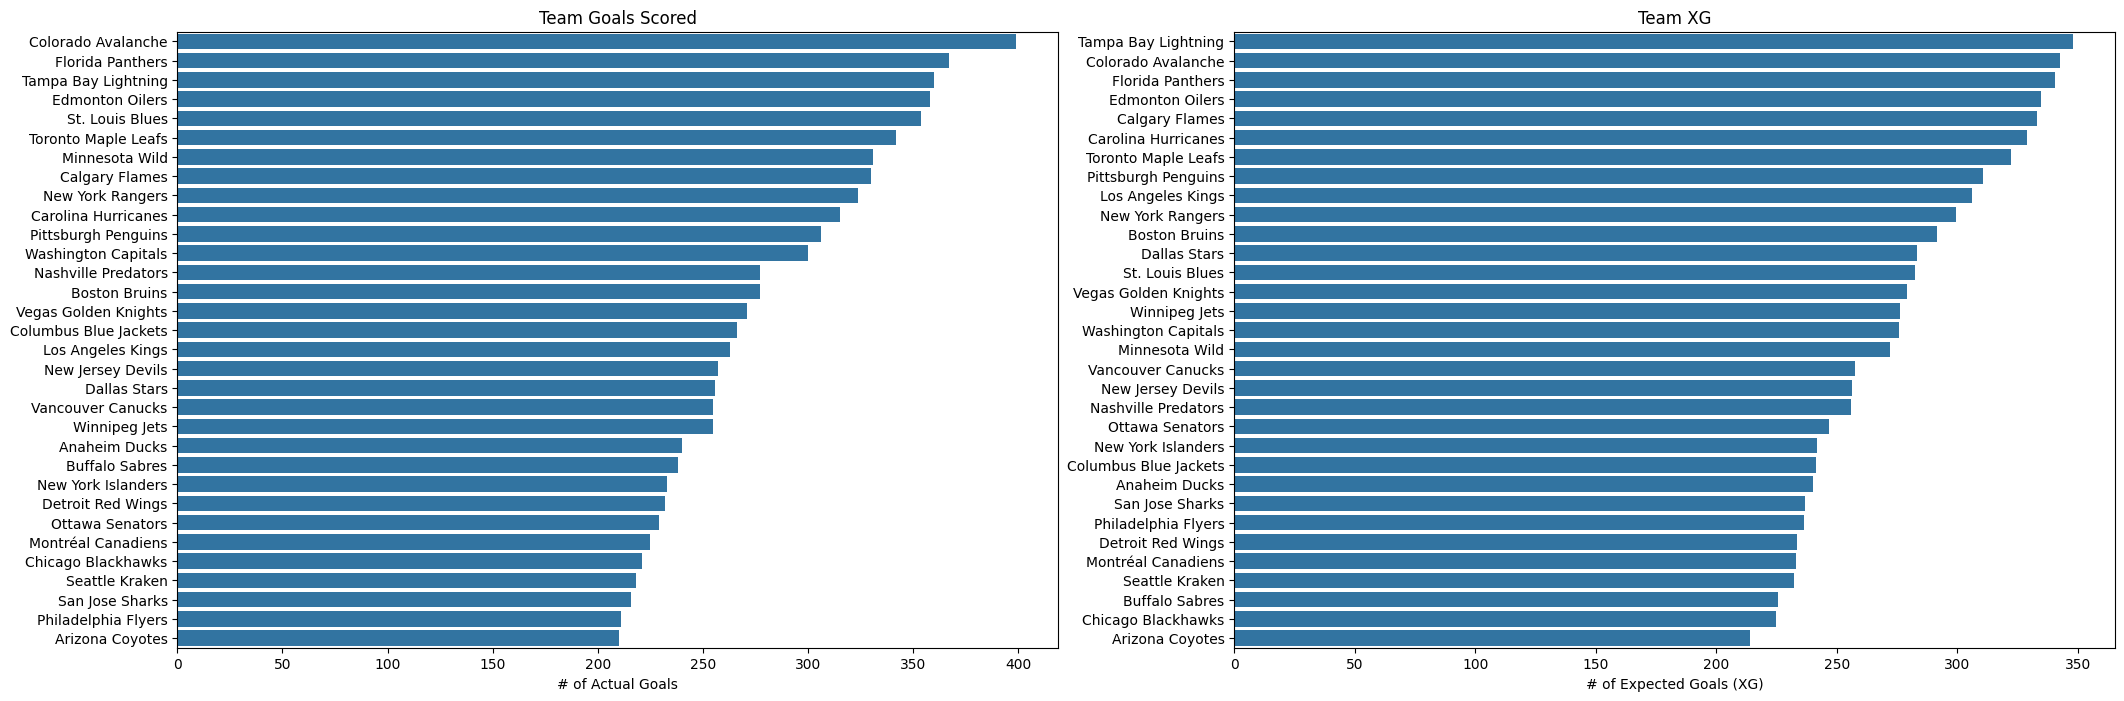

In [ ]:
df_num_goals = team_XG.sort_values('num_goals', ascending=False)
df_exp_goals = team_XG.sort_values('team_XG', ascending=False)

fig, axs = plt.subplots(1,2, figsize=(25,8))

sns.barplot(x='num_goals',y='event_team', data=df_num_goals, ax=axs[0])
axs[0].set_xlabel('# of Actual Goals')
axs[0].set_ylabel('')
axs[0].set_title('Team Goals Scored')

sns.barplot(x='team_XG',y='event_team', data=df_exp_goals, ax=axs[1])
axs[1].set_xlabel('# of Expected Goals (XG)')
axs[1].set_ylabel('')
axs[1].set_title('Team XG')

In [ ]:
# Compute the difference
team_XG['diff'] = team_XG['num_goals']-team_XG['team_XG']

# Compute the ratio
team_XG['ratio'] = team_XG['num_goals']/team_XG['team_XG']

Text(0.5, 1.0, 'Actual Goals / Expected Goals')

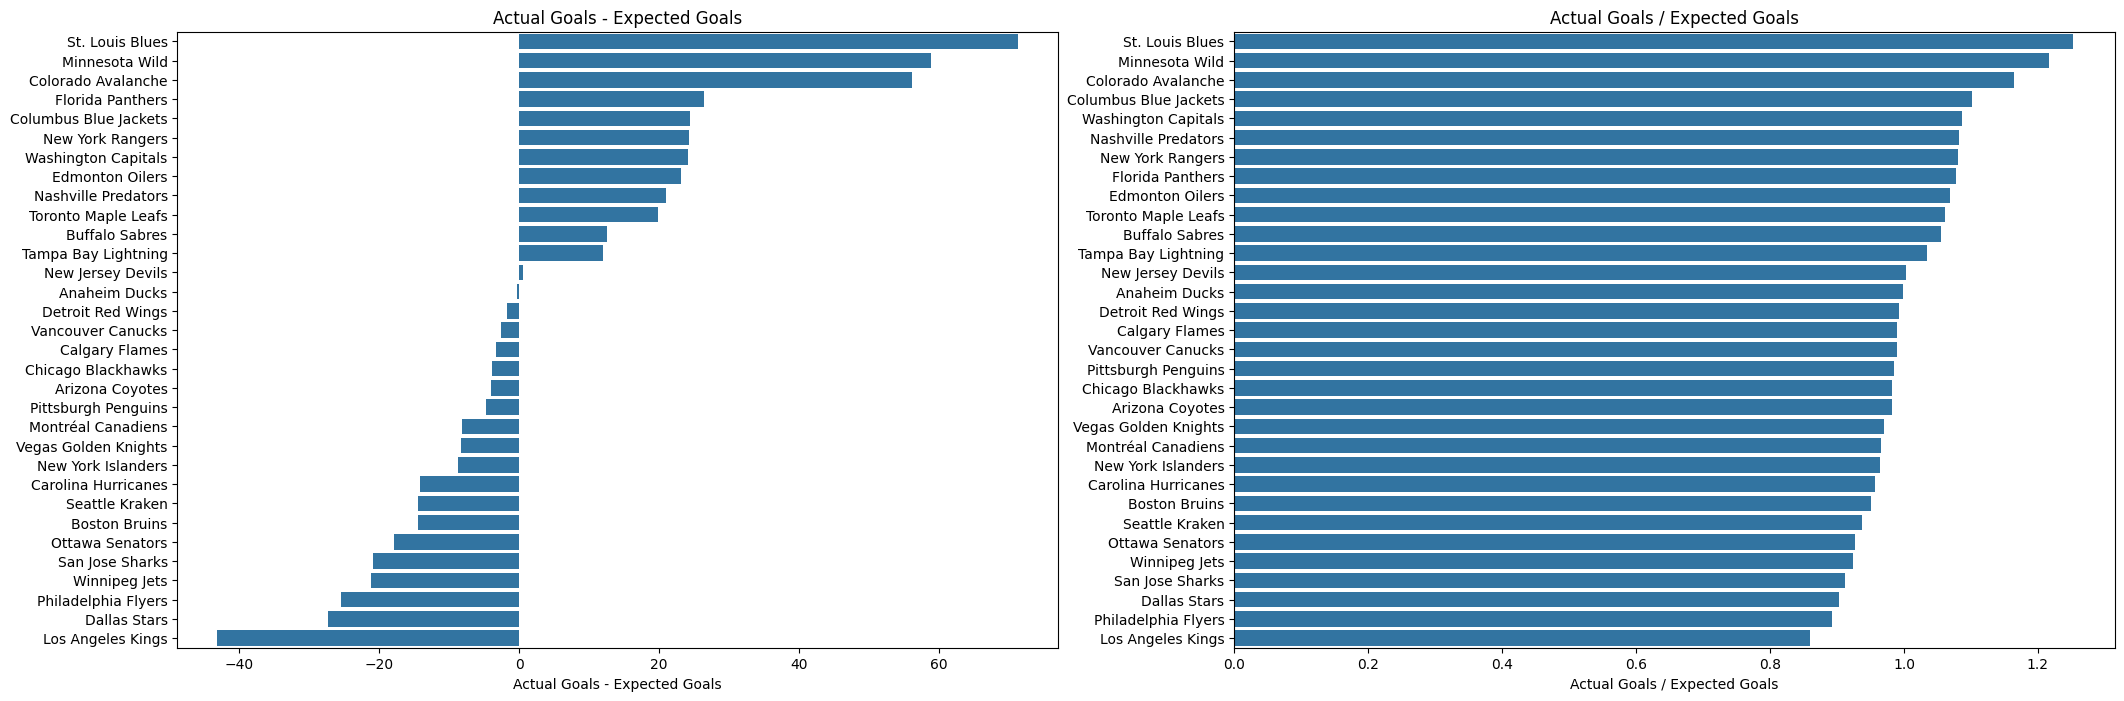

In [ ]:
df_diff_goals = team_XG.sort_values('diff', ascending=False)
df_ratio_goals = team_XG.sort_values('ratio', ascending=False)

fig, axs = plt.subplots(1,2, figsize=(25,8))

sns.barplot(x='diff',y='event_team', data=df_diff_goals, ax=axs[0])
axs[0].set_xlabel('Actual Goals - Expected Goals')
axs[0].set_ylabel('')
axs[0].set_title('Actual Goals - Expected Goals')

sns.barplot(x='ratio',y='event_team', data=df_ratio_goals, ax=axs[1])
axs[1].set_xlabel('Actual Goals / Expected Goals')
axs[1].set_ylabel('')
axs[1].set_title('Actual Goals / Expected Goals')


- The St. Louis Blues scored about 20% more goals than what was expected of them based on their shot quality.
- The Los Angeles Kings scored about 20% fewer goals than what was expected of them based on their shot quality.

#### Additional questions you might want to answer...
- Within the best and worst teams, are the goals typically scored by a small number of their players or are they more spread out?
- Is there some kind of optimal about of goal sharing that lower performing teams should asipre to have?

## What else can be done?
- We can certainly also try different models.
- Nothing says we have to stick to logistic regression.
- We could add in regularlizations.
- We could use more sophisticated models (e.g., support vector machines, random forests, XGBoost, LightGBM, neural networks)